In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import numpy as np
from statsmodels.tsa.seasonal import STL
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost.sklearn import XGBRegressor
import warnings
warnings.filterwarnings("ignore")
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import LSTM


ModuleNotFoundError: No module named 'pandas'

In [7]:
train = pd.read_csv("dataset/train.csv", index_col="date", parse_dates=True)

In [8]:
store_num = len(train["store"].unique())
item_num = len(train["item"].unique())
print(f"number of store:{store_num}, number of item: {item_num}")

number of store:10, number of item: 50


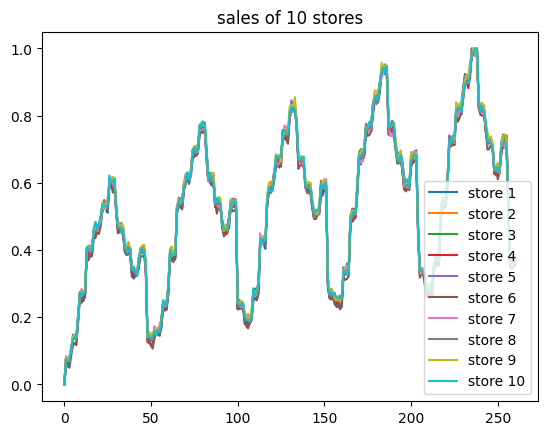

In [9]:
for i in range(1,11):
    store_data = train[train.store==i].resample("w").sum()
    scaler = MinMaxScaler(feature_range=(0, 1))
    store_data = scaler.fit_transform(store_data)
    label = "store "+str(i)
    plt.plot(store_data[:,2], label= label)
    plt.legend(loc="best")
    plt.title("sales of 10 stores")



based on these plots, the same seaonality pattern is evident for each store, each items. now we check the probablity distribution of sales data which is far from normal distribution.

Skewnes = 0.87, kurtosis = 0.51


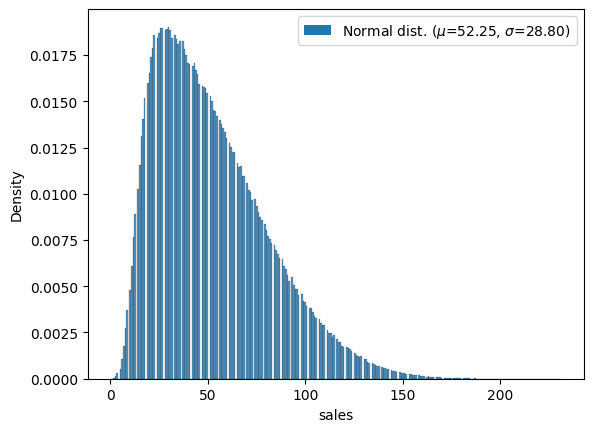

In [10]:
ax = sns.histplot(train.sales, stat="density")
mu, sigma = norm.fit(train.sales)
plt.legend(["Normal dist. ($\mu$={:.2f}, $\sigma$={:.2f})".format(mu,sigma)], loc="best")
print("Skewnes = {:.2f}, kurtosis = {:.2f}".format(train.sales.skew(), train.sales.kurt()))

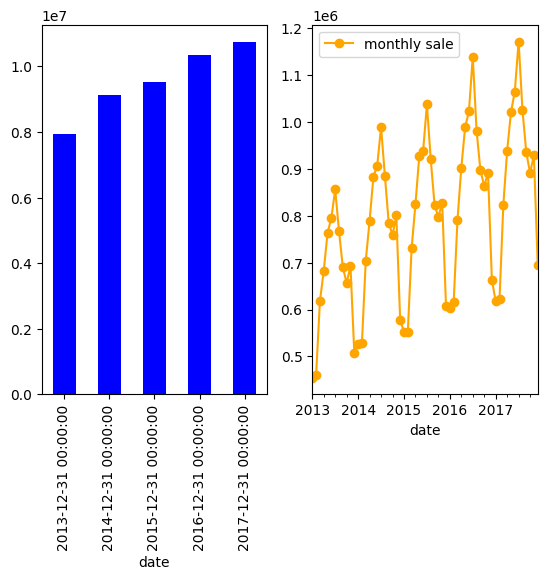

In [11]:
yearly_sale = train.sales.resample("y").sum()
monthly_sale = train.sales.resample("m").sum()
plt.subplot(121)
yearly_sale.plot(kind="bar", color="blue", label="yearly sale")
plt.subplot(122)
monthly_sale.plot(marker="o", color="orange", label="monthly sale")
plt.legend(loc="best")

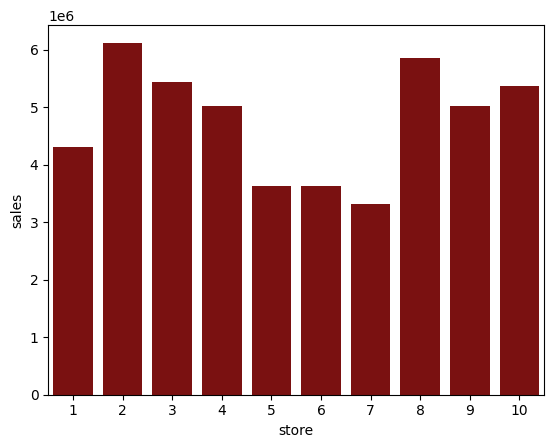

In [12]:
store_sales = train.groupby("store")["sales"].sum().reset_index()
sns.barplot(x=store_sales.store, y=store_sales.sales, color="darkred")
plt.show()

In [13]:
print(f"the monthly avrage sales of 5 years {monthly_sale.mean()}$")
print(f"the monthly avrage sales of last 12 months {monthly_sale[-12:].mean()}$")

the monthly avrage sales of 5 years 795075.2$
the monthly avrage sales of last 12 months 894478.3333333334$


seasonality of the dataset:

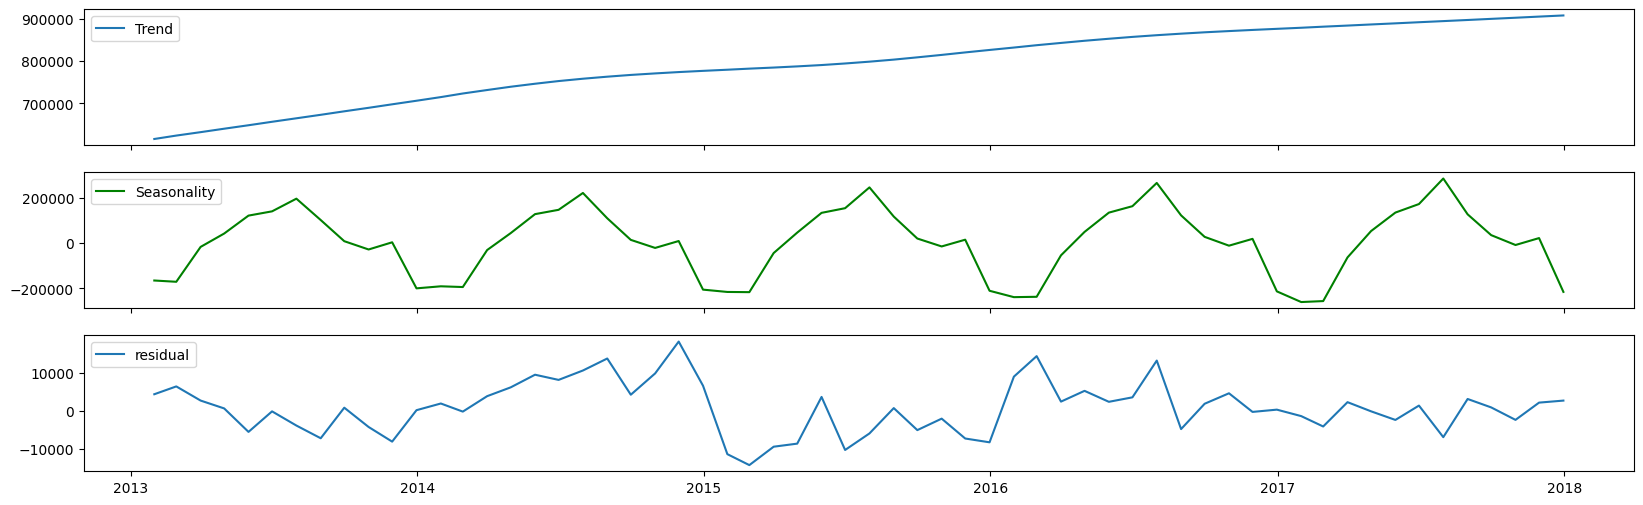

In [14]:
def plot_timeseries(sales):
    fig, axes = plt.subplots(3, 1, sharex=True, sharey=False)
    fig.set_figheight(6)
    fig.set_figwidth(20)
    stl = STL(sales)
    result = stl.fit()
    seasonal, trend, residual = result.seasonal, result.trend, result.resid


    axes[1].plot(seasonal, 'g', label='Seasonality')
    axes[1].legend(loc='upper left')
    
    axes[0].plot(trend, label='Trend')
    axes[0].legend(loc='upper left')

    axes[2].plot(residual, label='residual')
    axes[2].legend(loc='upper left')

monthly_sale = train.resample("m").sum()
plot_timeseries(monthly_sale.sales)

ARIMA modeling

based onthe evident seasonality it is recomended to use SARIMA model for prediction


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


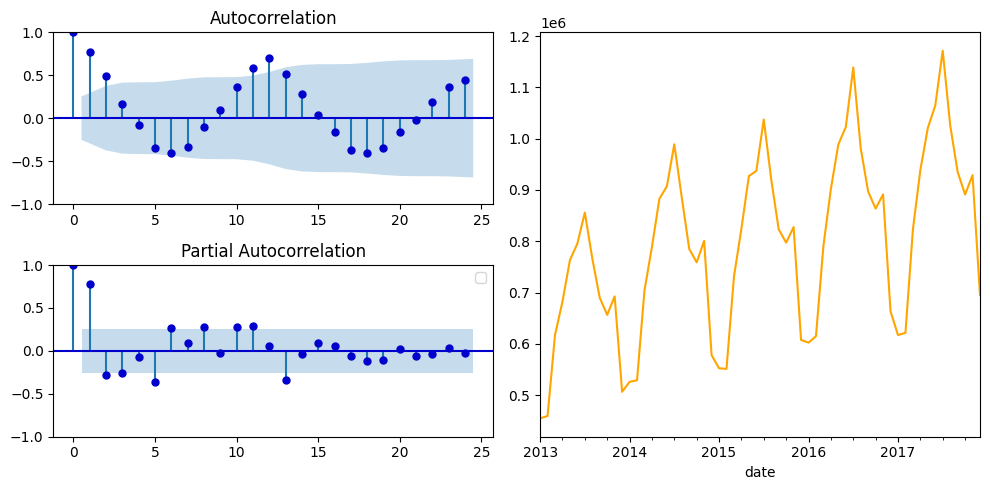

In [15]:

def plot_lag(timeseries, lags=1):
    law  = plt.subplot(122)
    acf  = plt.subplot(221)
    pacf = plt.subplot(223)
    timeseries.plot(ax=law, figsize=(10, 5), color='orange', label="sales diffrence")
    plt.legend(loc="best")
    # Plot the autocorrelation function:
    smt.graphics.plot_acf(timeseries, lags=lags, ax=acf, color='mediumblue')
    smt.graphics.plot_pacf(timeseries, lags=lags, ax=pacf, color='mediumblue')
    plt.tight_layout()


data = monthly_sale.sales
plot_lag(data, lags=24)

every 12 sample we get the repeatition of the deacreasing algorithm, so we condisder 12 perevious sales difference as input for regressor

In [16]:
def build_arima_data(data):
    da_data = data.resample("m").sum().sales_diff
    da_data = da_data.dropna()
    return da_data

def sarimax_model(Data):
    data = pd.DataFrame()
    data["sales_diff"] = Data
    sar = sm.tsa.statespace.SARIMAX(data.sales_diff, order=(12, 0, 0),
                                    seasonal_order=(0, 1, 0, 12),
                                    trend='c').fit()
    
    start, end, dynamic = 40, 100, 7
    data['pred_value'] = sar.predict(start=start, end=end, dynamic=dynamic)
    pred_df = data.pred_value[start+dynamic:end]
    
    data[["sales_diff","pred_value"]].plot(color=['blue', 'Red'])
    plt.legend(loc='upper left')
    
    model_scores = {}
    
    rmse = np.sqrt(mean_squared_error(data.sales_diff[-12:], data.pred_value[-12:]))
    mae = mean_absolute_error(data.sales_diff[-12:], data.pred_value[-12:])
    r2 = r2_score(data.sales_diff[-12:], data.pred_value[-12:])
    model_scores['ARIMA'] = [rmse, mae, r2]
    
    print(f"RMSE: {rmse}\nMAE: {mae}\nR2 Score: {r2}")
    
    return sar, data, pred_df

RMSE: 16640.59905237423
MAE: 13449.690864504277
R2 Score: 0.9902290928577867


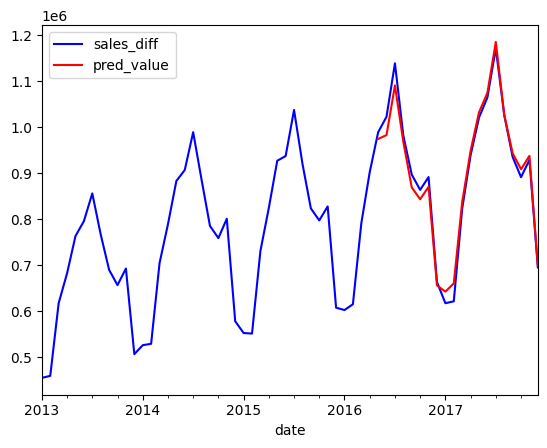

In [17]:
sar, datatime_df, predictions = sarimax_model(monthly_sale.sales)

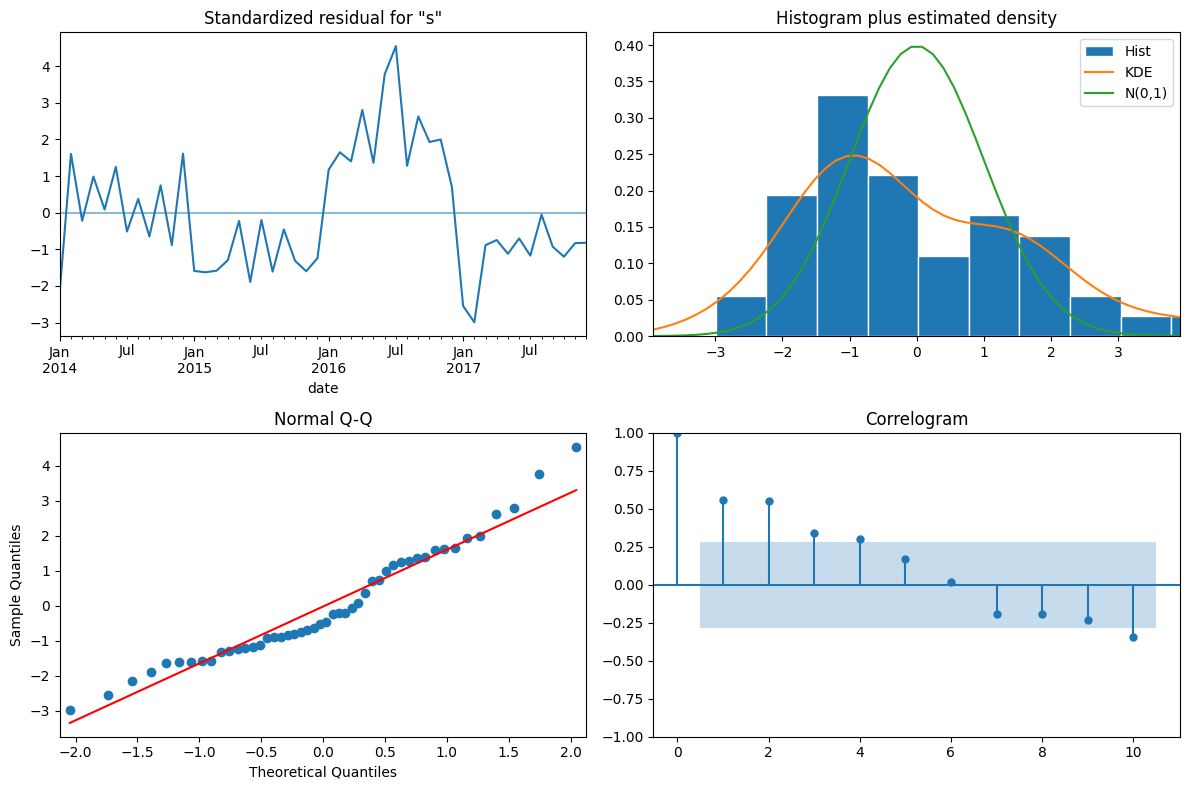

In [18]:
sar.plot_diagnostics(figsize=(12, 8))
plt.tight_layout()

generating features for regressor model with 1 to 12 time lag difference:

In [19]:
def feature_generator(timeseries, lags=12):
    feature_df = timeseries.copy()
    for i in range(1, lags+1):
        col_name = "lags_" + str(i)
        feature_df[col_name] = timeseries["sales_diff"].shift(i)
        feature_df = feature_df.dropna()
    return feature_df

def get_diff(data):
    data["sales_diff"] = data.sales.diff()
    data= data.dropna()
    return data

stationary_df = get_diff(monthly_sale)
sales_df = stationary_df[["sales", "sales_diff"]]
model_df = feature_generator(sales_df,lags=12)
model_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 47 entries, 2014-02-28 to 2017-12-31
Freq: M
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   sales       47 non-null     int64  
 1   sales_diff  47 non-null     float64
 2   lags_1      47 non-null     float64
 3   lags_2      47 non-null     float64
 4   lags_3      47 non-null     float64
 5   lags_4      47 non-null     float64
 6   lags_5      47 non-null     float64
 7   lags_6      47 non-null     float64
 8   lags_7      47 non-null     float64
 9   lags_8      47 non-null     float64
 10  lags_9      47 non-null     float64
 11  lags_10     47 non-null     float64
 12  lags_11     47 non-null     float64
 13  lags_12     47 non-null     float64
dtypes: float64(13), int64(1)
memory usage: 5.5 KB


In [20]:
def train_test(data):
    data = data.drop(["sales"], axis=1)
    train, test = data[:-12].values, data[-12:].values
    return train, test
train_set, test_set = train_test(model_df)

In [21]:
def scale_Data(train, test):
    scaler = MinMaxScaler(feature_range=(-1,1))
    scaler = scaler.fit(train)
    train_scale = scaler.transform(train)
    test_scale = scaler.transform(test)
    X_train, y_train = train_scale[:,1:], train_scale[:,0]
    X_test, y_test = test_scale[:,1:], test_scale[:,0]
    return X_train, y_train, X_test, y_test, scaler

def reverse_scale(y_pred, X_test, scaler):
    pred_test_set = np.zeros([len(y_pred),13])
    pred_test_set[:,0]= y_pred
    pred_test_set[:,1:]= X_test
    pred_test_set_inverted = scaler.inverse_transform(pred_test_set)
    return pred_test_set_inverted


def prediction_df(unscale_predictions, origin_df):
    result_list = []
    sales_dates = list(origin_df.index[-13:])
    act_sales = list(origin_df[-13:].values)

    for index in range(0, len(unscale_predictions)):
        result_dict = {}
        result_dict['pred_value'] = int(unscale_predictions[index][0] + act_sales[index])
        result_dict['date'] = sales_dates[index + 1]
        result_list.append(result_dict)

    df_result = pd.DataFrame(result_list)

    return df_result

def plot_results(results, origin_df, model_name):
    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(x=origin_df.index, y=origin_df.values, ax=ax, label='Original', color='blue')
    sns.lineplot(x=results.date, y=results.pred_value, ax=ax, label='Predicted', color='red')
    ax.set(xlabel = "Date", ylabel = "Sales", title = f"{model_name} Sales Forecasting Prediction") 
    ax.legend(loc='best')

model_scores = {}
def get_scores(unscale_df, origin_df, model_name):
    rmse = np.sqrt(mean_squared_error(origin_df.values[-12:],  unscale_df.pred_value[-12:]))
    mae = mean_absolute_error(origin_df.values[-12:], unscale_df.pred_value[-12:])
    r2 = r2_score(origin_df.values[-12:], unscale_df.pred_value[-12:])
    model_scores[model_name] = [rmse, mae, r2]
    print(f"RMSE: {rmse}\nMAE: {mae}\nR2 Score: {r2}")




defining a function for different regressor model:

In [22]:
def regressive_model(train, test, model, model_name):
    X_train, y_train, X_test, y_test, scaler_obj = scale_Data(train, test)
    mod = model
    mod.fit(X_train, y_train)
    prediction = mod.predict(X_test)
    unscaled = reverse_scale(prediction, X_test, scaler_obj)
    origin = monthly_sale.sales
    unscaled_df = prediction_df(unscaled, origin)
    get_scores(unscaled_df, origin, model_name)
    plot_results(unscaled_df, origin, model_name)


RMSE: 16221.040790693221
MAE: 12433.0
R2 Score: 0.9907155879704752


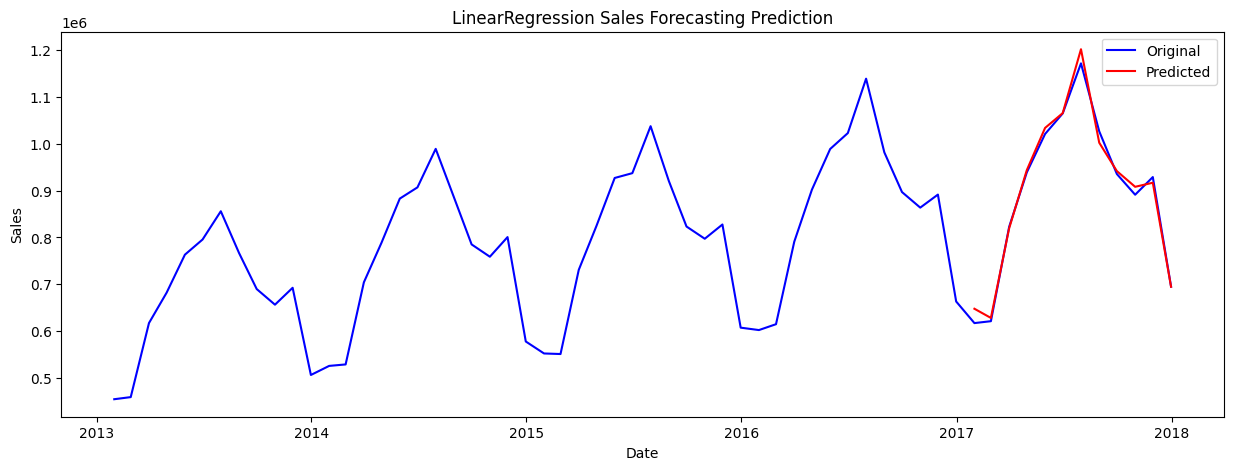

In [23]:
y_pred = regressive_model(train_set, test_set, LinearRegression(), 'LinearRegression')

RMSE: 13574.854581787116
MAE: 11649.75
R2 Score: 0.993497694881536


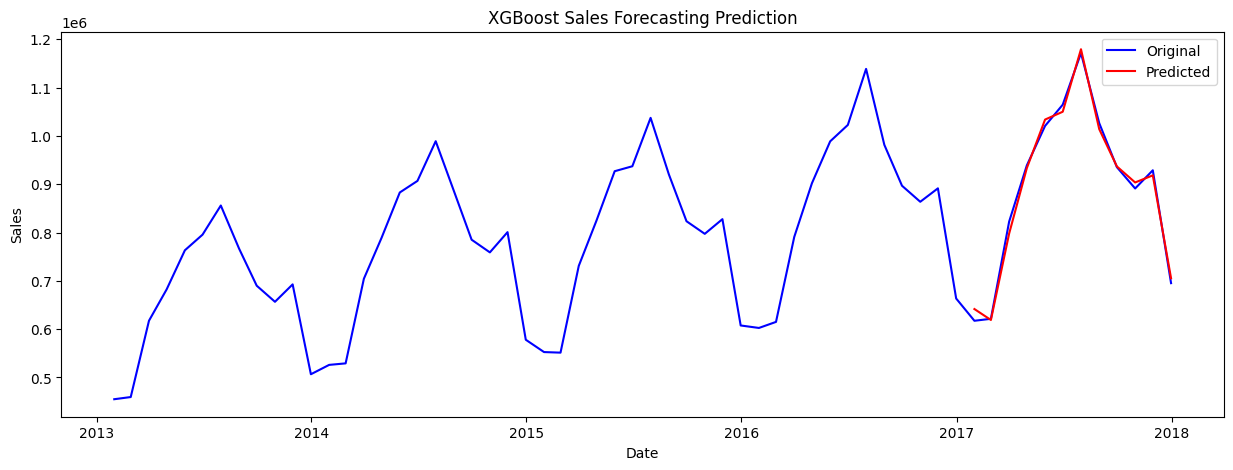

In [24]:
regressive_model(train_set, test_set, XGBRegressor(n_estimators=100,max_depth=3, 
                                           learning_rate=0.2,objective='reg:squarederror'), 'XGBoost')

LSTM model

In [25]:
def lstm_model(train_data, test_data):

    X_train_f, y_train, X_test_f, y_test, scaler_object = scale_Data(train_data, test_data)
    
    X_train = X_train_f.reshape(X_train_f.shape[0], 1, X_train_f.shape[1])
    X_test = X_test_f.reshape(X_test_f.shape[0], 1, X_test_f.shape[1])
   
    
    # Build LSTM:
    model = Sequential()
    model.add(LSTM(4, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), 
                   stateful=True))
    model.add(Dense(1))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=50, batch_size=1, verbose=1, 
              shuffle=False)
    predictions = model.predict(X_test,batch_size=1)
    origin_df = monthly_sale.sales
    unscaled = reverse_scale(predictions.ravel(), X_test_f, scaler_object)
    unscaled_df = prediction_df(unscaled, origin_df)
    get_scores(unscaled_df, origin_df, 'LSTM')
    plot_results(unscaled_df, origin_df, 'LSTM')



Epoch 1/50
35/35 [==============================] - 2s 1ms/step - loss: 0.2772 - accuracy: 0.0000e+00
Epoch 2/50
35/35 [==============================] - 0s 1ms/step - loss: 0.2410 - accuracy: 0.0000e+00
Epoch 3/50
35/35 [==============================] - 0s 1ms/step - loss: 0.2134 - accuracy: 0.0000e+00
Epoch 4/50
35/35 [==============================] - 0s 1ms/step - loss: 0.1897 - accuracy: 0.0000e+00
Epoch 5/50
35/35 [==============================] - 0s 1ms/step - loss: 0.1690 - accuracy: 0.0000e+00
Epoch 6/50
35/35 [==============================] - 0s 1ms/step - loss: 0.1507 - accuracy: 0.0000e+00
Epoch 7/50
35/35 [==============================] - 0s 1ms/step - loss: 0.1345 - accuracy: 0.0000e+00
Epoch 8/50
35/35 [==============================] - 0s 1ms/step - loss: 0.1200 - accuracy: 0.0000e+00
Epoch 9/50
35/35 [==============================] - 0s 1ms/step - loss: 0.1071 - accuracy: 0.0286
Epoch 10/50
35/35 [==============================] - 0s 1ms/step - loss: 0.0955 - accu

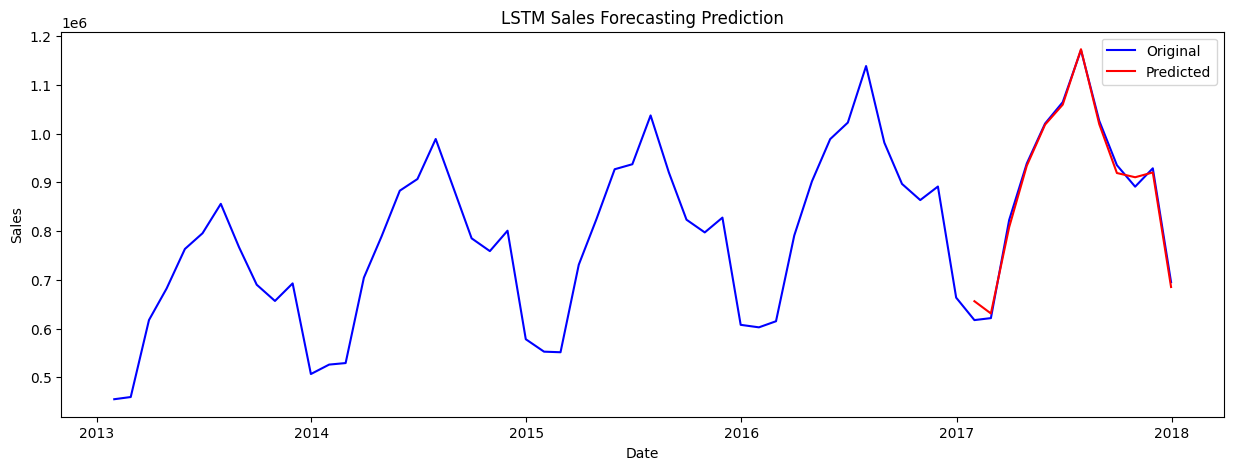

In [26]:
 lstm_model(train_set, test_set)
